## Sugarscape
based on code from ch. 11 Agent-Based Models in [Think Complexity, 2nd edition](https://thinkcomplex.com).
Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

**Sugarscape** is a model for artificially intelligent agent-based social simulation following some or all rules presented by Joshua M. Epstein & Robert Axtell in their book [Growing Artificial Societies](https://archive.org/details/growingartificia00epst/page/224). [https://en.wikipedia.org/wiki/Sugarscape](https://en.wikipedia.org/wiki/Sugarscape)

This is an abstract model of independent agents competing for a finite renewable resource.  It is useful for understanding the properties and expected default behaviour for any system with this underlying structure.

In [237]:
import os
if not os.path.exists('utils.py'):
    !wget https://raw.githubusercontent.com/AllenDowney/ThinkComplexity2/master/notebooks/utils.py
if not os.path.exists('Cell2D.py'):
  !wget  https://raw.githubusercontent.com/pearcej/complex-colab/master/notebooks/Cell2D.py

!pip install empiricaldist

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
from itertools import chain

from Cell2D import Cell2D, draw_array
from utils import decorate, three_frame
from empiricaldist import Cdf

You should consider upgrading via the '/Users/Joseph/.pyenv/versions/3.8.12/envs/jupyter/bin/python3.8 -m pip install --upgrade pip' command.


### Grid Locations
Grid locations in the model are (x, y) cell coordinates.
Handy helper function to create the complete list of cell coordinates for an n x m grid...

In [238]:
def make_locations(n, m):
    """ Return list of (x, y) coordinates for all locations on n x m grid """
    return [(i, j) for i in range(n) for j in range(m)]

In [239]:
make_locations(2, 3)

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

## The Agent
In sugarscape, there are free-roving agents who harvest resources (sugar) from the environment (a Cell2D grid).   Each agent has a set of individualized "traits" that define its behaviours and create differentiation in "fitness" within the population of Agents.  An Agent's life mission is to simply accumulate as much sugar as possible.

### Agent traits and behaviours
Each Agent is defined by 4 attributes:
 - vision: a positive integer that defines how far the agent can see and move in a single time step
 - metabolism: a positive number that defines how much sugar the agent "burns" to stay alive
 - lifespan: a positive integer defining how many timesteps the agent will live before dying of old age
 - sugar: the store of sugar the agent has accumulated over its lifetime, less the amount it has metabolized.

Agent behaviour is fairly simple - at each time step:
 - find the "highest value" cell within view (radius defined by vision)
 - move to that cell and consume all the sugar
 - metabolize some sugar to stay alive and age one time unit
 - die if age exceed lifespan or if sugar store completely depleted.

In [240]:
class Agent:
    max_vision=6
    max_metabolism=4
    lifespan_range=(10000, 10000)
    initial_sugar_range=(5, 25)

    def __init__(self, loc=(0,0), vision=None, metabolism=None, lifespan=None, sugar=None):
        """Creates a new agent at the given location.
        
        loc: (x,y) tuple coordinate
        params: define agent's attributes - by default these are drawn from uniform distributions defined by class variables
        """
        self.loc = tuple(loc)
        self.age = 0

        # set attributes or draw from uniform distributions defined by class
        self.vision = vision or np.random.randint(1, self.max_vision+1)
        self.metabolism = metabolism or np.random.uniform(1, self.max_metabolism)
        self.lifespan = lifespan or np.random.uniform(*self.lifespan_range)
        self.sugar = sugar or np.random.uniform(*self.initial_sugar_range)

    @classmethod
    def make_agents(cls, num_agents, n, m):
        """ Factory: return a list Agent objects at random locations in n x m grid """
        # all (x,y) locations in an n x m grid...
        locations = make_locations(n, m)
        assert num_agents <= len(locations)  # verify pre-condition: there are enough locations for all agents
        # randomize the locations and construct the desired number of agents at random locations
        np.random.shuffle(locations)
        return [cls(locations[i]) for i in range(num_agents)]

    def visible_locations(self):
        """Return a list of (x,y) cell coordinates that are "visible" to this agent, ordered by distance from agent """
        def cardinal_neighbours(x, y, dist):
            """ A randomly ordered list of cardinal cells at the given distance from given (x,y) location."""
            a = [(x-dist, y), (x+dist, y), (x, y-dist), (x, y+dist)]
            np.random.shuffle(a)
            return a

        arrays = (cardinal_neighbours(*self.loc, distance) for distance in range(1, self.vision+1))
        return list(chain(*arrays))  # chain creates a single iterable from all the cardinal neighbours lists

    def find_highest_value_cell(self, env):
        """Finds the visible cell with the most sugar within this agent's vision.

        env: the Sugarscape environment this agent lives in
        returns: tuple, coordinates of highest value cell
        """
        # find all empty, visible cells, "wrapping" vision around edges of environment
        visible_locs = env.wrap_locations( self.visible_locations() )
        empty_locs = env.get_empty_locations(visible_locs)

        # return the cell with the highest sugar content from empty, visible cells...
        if len(empty_locs) > 0:
            i = np.argmax(env.get_sugar(empty_locs)) # (in case of tie, argmax returns the first, which is the closest)
            return empty_locs[i]
        else:  # there are no empty visible cells, so only choice is to stay put
            return self.loc

    def step(self, env):
        """Look around, move, and harvest.
        
        env: Sugarscape
        """
        self.loc = self.find_highest_value_cell(env)
        self.sugar += env.harvest(self.loc) - self.metabolism
        self.age += 1

    def is_starving(self):
        """Checks if sugar has gone negative."""
        return self.sugar < 0
    
    def is_old(self):
        """Checks if lifespan is exceeded."""
        return self.age > self.lifespan

### Agent Tests
Here we put an Agent through its paces so we are confident it works as expected.

In [241]:
agent = Agent((5, 5), vision=2, lifespan=42, sugar=5)
assert not agent.is_starving() and not agent.is_old()
agent.age = 43
assert agent.is_old()
agent.sugar = -1
assert agent.is_starving()
# check agent's vision...
visible = agent.visible_locations()
assert len(visible) == 8  # 2 in each of the 4 cardinal directions
assert (4, 5) in visible and visible.index((4, 5)) < 4     # locations close by are listed first...
assert (5, 7) in visible and visible.index((5, 7)) >= 4  # with most distant locations at end of list
# here is the list of all visible locations...
visible

[(5, 6), (6, 5), (4, 5), (5, 4), (5, 3), (5, 7), (7, 5), (3, 5)]

In [242]:
# test the Factory method to "bulk order" agents...
n, m = 20, 40
agents = Agent.make_agents(10, n, m)  # create 10 agents at random locations in n x m grid
for agent in agents:
    x,y = agent.loc
    assert 0 <= x < n and 0 <= y < m
# here's the random locations agents got placed at...
[agent.loc for agent in agents]

[(18, 3),
 (7, 16),
 (14, 29),
 (4, 20),
 (11, 3),
 (19, 23),
 (0, 26),
 (3, 11),
 (10, 17),
 (12, 35)]

#### Distribution of Agent traits
Using the `make_agents` factory, the agents' "traits" are drawn from a uniform distribution.

The distribution of vision is uniform from 1 to 6.

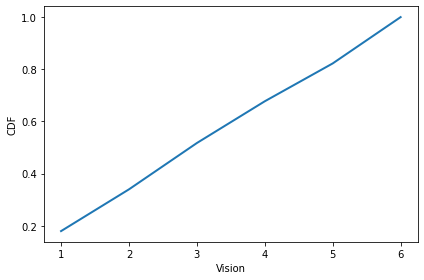

In [243]:
agents = Agent.make_agents(400, 50, 50)  # create 10 agents at random locations in n x m grid

cdf = Cdf.from_seq(agent.vision for agent in agents)
cdf.plot()
decorate(xlabel='Vision', ylabel='CDF')

The distribution of metabolism is uniform from 1 to 4.

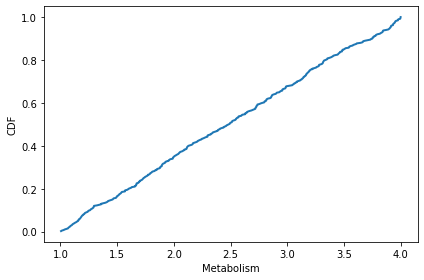

In [244]:
cdf = Cdf.from_seq(agent.metabolism for agent in agents)
cdf.plot()
decorate(xlabel='Metabolism', ylabel='CDF')

The distribution of initial endowment of sugar is uniform from 5 to 25.

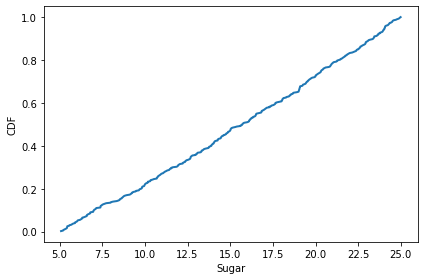

In [245]:
cdf = Cdf.from_seq(agent.sugar for agent in agents)
cdf.plot()
decorate(xlabel='Sugar', ylabel='CDF')

## The Capacity Landscape
Growth of "sugar" growth is limited by conditions in each cell.
Each cell defines a fixed "capacity" - the maximum amount of sugar that cell can yield in one time step.
In the "classic" Sugarscape simulation, capacity occurs in 2 "mounds" at bottom-left and top-right of grid...

In [246]:
def make_capacity_landscape(n):
    """ Return nxn array with fixed "capacity" for each cell."""
    # for the classic model, the landscape has 2 mounds of high-capacity sugar growing
    # compute the distance of each cell from these 2 peaks.
    lower_left = int(.3 * n)
    dist1 = distances_from(n, lower_left, lower_left)
    upper_right = int(.6 * n)
    dist2 = distances_from(n, upper_right, upper_right)
    dist = np.minimum(dist1, dist2)

    return get_capacity(dist)  # capacity is inversely proportional to distance from the 2 "peaks"

def distances_from(n, i, j):
    """Computes an n x n 2D array of distances from coordinate (i, j)

    n: size of the array
    i, j: coordinates to find distance from

    returns: array of float
    """
    X, Y = np.indices((n, n))
    return np.hypot(X-i, Y-j)

def get_capacity(distance_to_peak, contours=(21, 16, 11, 6)):
    """ return array of capacities, inversely related to distances, digitized by the distance contours

    distance_to_peak: 2D array of distances to nearest "peak"

    contours: a list of distances that form contours with increasing capacity in each contour
    """
    return np.digitize(distance_to_peak, contours)

### Capacity Landscape Tests
Verify the Capacity Landscape and it's helper functions work as expected.

In [247]:
dist = distances_from(5, 2, 2)
assert dist.shape==(5,5) and (dist >=0).all() and (dist <= 3).all()
dist

array([[2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.        , 1.        , 0.        , 1.        , 2.        ],
       [2.23606798, 1.41421356, 1.        , 1.41421356, 2.23606798],
       [2.82842712, 2.23606798, 2.        , 2.23606798, 2.82842712]])

In [248]:
bins = [3, 2, 1]
capacity = get_capacity(dist, bins)
assert capacity.shape == dist.shape and capacity[(2,2)] == 3 and capacity[(0,0)] == 1
capacity

array([[1, 1, 1, 1, 1],
       [1, 2, 2, 2, 1],
       [1, 2, 3, 2, 1],
       [1, 2, 2, 2, 1],
       [1, 1, 1, 1, 1]])

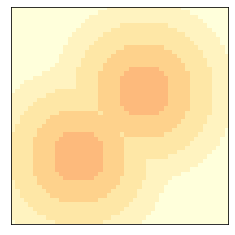

In [249]:
draw_array(make_capacity_landscape(50), cmap='YlOrRd', vmax=9, origin='lower')

## The Sugarscape 2D grid
Defines the "landscape" of resources (sugar) the agents move around on and consume.

### Sugarscape data and behaviours
Sugarscape is a Cell2D with 4 core attributes:
 - array: the array of cells with some quantity of sugar in each cell
 - growth_rate: the rate at which sugar replenishes
 - capacity: an array the specifies the max. capacity of each cell - each cell in array is limited to this much sugar
 - agents: a list of Agent objects that are living in the Sugarscape

Sugarscape behaviour is also fairly simple:
 - at each timestep, simply give every agent a chance to "step" and grow some sugar in each cell that is below capacity
 - provide services to allow agents to:
   - treat the Sugarscape like a globe -- coordinates "wrap" top-bottom and left=right
   - find empty locations in the Sugarscape where they might migrate to
   - "see" how much sugar is in any location in the Sugarscape, and "harvest" that sugar

In [250]:
class Sugarscape(Cell2D):
    """Represents an Epstein-Axtell Sugarscape."""

    def __init__(self, n, agents, grow_rate=1, replace_agents=False):
        """Initializes the attributes.

        n: number of rows and columns
        agents: iterable of agents, with random locations on (n, n)
        replace_agents: Agent model to use to replace dead agents with, or False for no replacement
        grow_rate: sugar re-growth rate
        """
        assert(len(agents) <= n**2)  # can't have more agents than there are grid cells

        self.n = n
        self.agents = agents
        self.grow_rate = grow_rate
        self.replace_agents = replace_agents

        # make the capacity array  (constant - capacity never changes - represents upper bound)
        self.capacity = make_capacity_landscape(n)
        # initially all cells are at capacity, this array is the dynamic state of sugar at each loc
        self.array = self.capacity.copy()

        # keep track of which cells are unoccupied
        self.unoccupied = set(make_locations(n, n)) - set(agent.loc for agent in self.agents)

        # tracking variables
        self.agent_count_seq = []

    def wrap_locations(self, locations):
        """ return listt of (x,y) locations, where each location is "wrapped" so it falls within the sugarscape grid

        locations: iterable of 2-tuple (x,y) locations, some of which may fall outside grid dimensions
        """
        return [(x%self.n, y%self.n) for x,y in locations]

    def get_empty_locations(self, locations):
        """ select and return list locations that are unoccupied """
        return [loc for loc in locations if loc in self.unoccupied]

    def get_sugar(self, locations):
        """ return list of sugar level at each location """
        return [self.array[loc] for loc in locations]

    def grow(self):
        """ add sugar to all cells and caps them by capacity."""
        self.array = np.minimum(self.array + self.grow_rate, self.capacity)

    def harvest(self, loc):
        """ remove and return the sugar from (x, y) `loc` """
        sugar = self.array[loc]
        self.array[loc] = 0
        return sugar

    def step(self):
        """ Execute one time step. """
        # loop through the agents in random order
        for agent in np.random.permutation(self.agents):
            # mark the agent's cell unoccupied and allow them to "step" to new location
            self.unoccupied.add(agent.loc)
            agent.step(self)

            # if the agent is dead, remove from model and potential replace with new agent
            if agent.is_starving() or agent.is_old():
                self.agents.remove(agent)
                if self.replace_agents:
                    self.add_agent(AgentModel=self.replace_agents)
            else:
                # otherwise mark its new cell as occupied
                self.unoccupied.remove(agent.loc)

        # update the time series tracking data
        self.agent_count_seq.append(len(self.agents))

        # grow back some sugar
        self.grow()
        return len(self.agents)

    def add_agent(self, AgentModel):
        """ return a new agent at a random, unoccuped location """
        new_agent = AgentModel( loc=random.sample(self.unoccupied, k=1)[0] )
        self.agents.append(new_agent)
        self.unoccupied.remove(new_agent.loc)
        return new_agent

    def draw(self):
        """Draws the Sugarscape with its agents """
        draw_array(self.array, cmap='YlOrRd', vmax=9, origin='lower')
        if self.agents:
            self._draw_agents()

    def _draw_agents(self):
        """ Draw the agents in centre of cell they occupy """
        # Transform from (col, row) to centre (x, y) of cell coordinate.
        rows, cols = np.transpose([agent.loc for agent in self.agents])
        xs = cols + 0.5
        ys = rows + 0.5
        plt.plot(xs, ys, '.', color='red')

### Sugarscape Tests
Put Sugarscape through a few controlled tests to verify it works as expected.

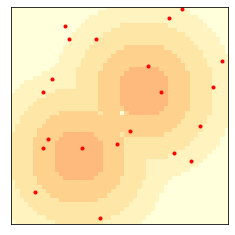

In [251]:
n = 50
n_agents = 20
env = Sugarscape(n, agents=Agent.make_agents(n_agents, n, n))

assert len(env.agents) == n_agents
# unoccupied cells
assert len(env.unoccupied) == n*n - len(env.agents)
assert not any(agent.loc in env.unoccupied for agent in env.agents)
# edge wrapping
assert env.wrap_locations([(-1, -1), (42, n+2), (n+2, 42)]) == [(n-1, n-1), (42, 2), (2, 42)]
# empty locations
agent_locations = [agent.loc for agent in env.agents]
assert env.get_empty_locations(agent_locations) == []
unoccupied = random.sample(env.unoccupied, k=5)
assert env.get_empty_locations(unoccupied+agent_locations) == unoccupied
# harvest
loc = (n//2, n//2)
sugar = env.get_sugar([loc])[0]
assert env.harvest(loc) == sugar
assert env.array[loc] == 0
# add an agent to unoccupied cell
env.add_agent(Agent)
assert len(env.agents) == n_agents+1
assert len(env.unoccupied) == n*n - len(env.agents)
assert not any(agent.loc in env.unoccupied for agent in env.agents)

env.draw()

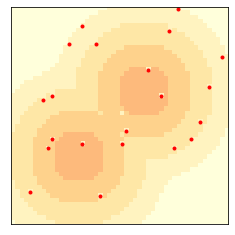

In [252]:
env.step()
env.draw()

## Experiments
### Immortal Agents
In the "classic" sugarscape model we will start experimenting with, Agents they never die of old age

In [253]:
class ImmortalAgent(Agent):
    """ An Agent that never dies from old age (but can still starve) """
    def is_old(self):
        """ immortal agents never get old! """
        return False

Start with 400 agents and compute the carrying capcity

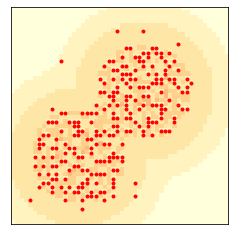

In [254]:
n = 50
n_agents = 400
env = Sugarscape(n, agents=ImmortalAgent.make_agents(n_agents, n, n))
env.animate(frames=50)

The number of agents levels off at the "carrying capacity":

In [255]:
len(env.agents)

246

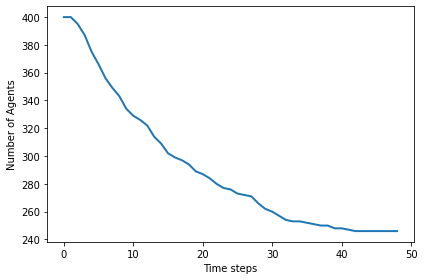

In [256]:
plt.plot(env.agent_count_seq)
decorate(xlabel='Time steps', ylabel='Number of Agents')

Generate figure from the textbook that shows the state of the system after 2 and 10 steps.

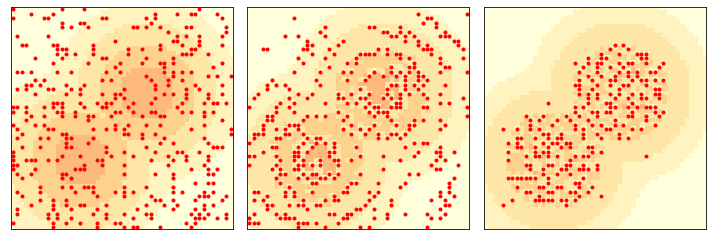

In [257]:
n = 50
n_agents = 400
env = Sugarscape(n, agents=ImmortalAgent.make_agents(n_agents, n, n))
three_frame(env, [0, 2, 98])

plt.show('figs/chap10-3')

**Exercise:** Experiment with different numbers of agents.  Try increasing or decreasing their vision or metabolism, and see what effect is has on carrying capacity.

## Sugarscape with finite lifespans
For these experiments, we want agents that "die" of old age.
To achieve this, we define a `MortalAgent` with a limited range of lifespans

In [258]:
class MortalAgent(Agent):
    """ The lifespan of a Mortal Agent is, sadly, fixed from "birth" from a uniform distribution """
    lifespan_range=(60, 100)

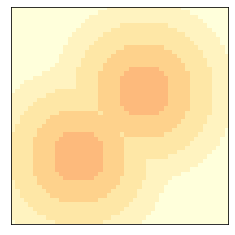

In [259]:
n = 50
env = Sugarscape(n, agents=MortalAgent.make_agents(5, n, n), replace_agents=False)
env.animate(frames=110)

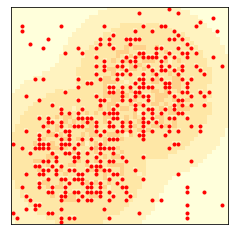

In [260]:
n = 50
n_agents = 400
env = Sugarscape(n, agents=MortalAgent.make_agents(n_agents, n, n), replace_agents=MortalAgent)
env.animate(frames=100)

### Wealth Inequality
With a fixed lifespan, agents can only accumulate so much sugar over their lives.  This allows us to measure the distribution of wealth among agents.  We find that this simple model produces significant equality, suggesting that wealth inequality may be "baked in" to systems where individual actors with differening life history traits are competing for resources.

After 100 time steps, the distribution of wealth is skewed to the right.  Most agents have very little sugar, but a few have a lot.

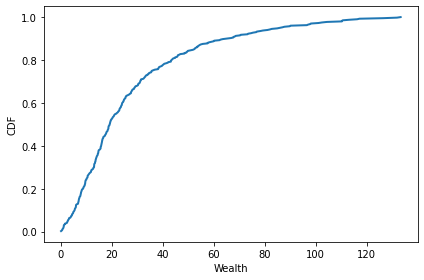

In [261]:
cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdf.plot()
decorate(xlabel='Wealth', ylabel='CDF')

In [262]:
cdf.quantile([0.25, 0.50, 0.75, 0.90])

array([10.3001468 , 19.10850936, 35.76618307, 65.25162489])

Starting with the same parameters, I'll run the model 500 steps, recording the distribution of wealth after each 100 steps:

In [263]:
np.random.seed(17)

n = 50
env = Sugarscape(n, agents=MortalAgent.make_agents(250, n, n), replace_agents=MortalAgent)

cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
cdfs = [cdf]
for i in range(5):
    env.loop(100)
    cdf = Cdf.from_seq(agent.sugar for agent in env.agents)
    cdfs.append(cdf)

After about 200 steps, the distribution is stationary (doesn't change over time).

On a log scale, it is approximately normal, possibly with a truncated right tail.

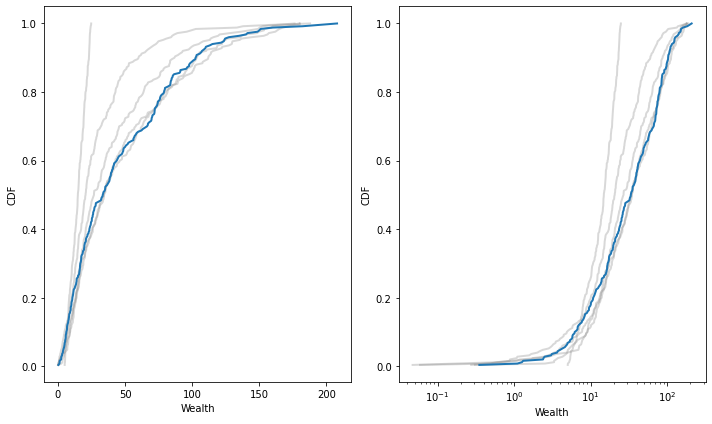

In [264]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)

def plot_cdfs(cdfs, **options):
    for cdf in cdfs:
        cdf.plot(**options)
        
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF')

plt.subplot(1, 2, 2)
plot_cdfs(cdfs[:-1], color='gray', alpha=0.3)
plot_cdfs(cdfs[-1:], color='C0')
decorate(xlabel='Wealth', ylabel='CDF', xscale='log')

plt.show('figs/chap10-4')

**Exercise:** Experiment with different starting conditions and agents with different vision, metabolism, and lifespan.  What effect do these changes have on the distribution of wealth?

## Migration in waves
This experiment shows the model appears to exhibit "emergent behaviour" (behaviours not explicitly coded into model logic).
When all the actors start on one of the mounds, they "migrate" to the other mound in waves.

For this experiment, we need actors who are capable of "seeing" across the valley to the other mound of sugar...

In [265]:
class FarsightedAgent(Agent):
    """ These agents need to be able to "see" across the valley to the other sugar mountain """
    max_vision = 16

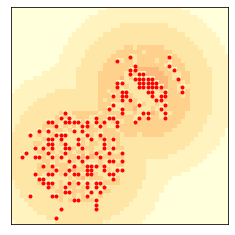

In [286]:
np.random.seed(17)
lower_left = (20, 20)
env = Sugarscape(50, agents=FarsightedAgent.make_agents(200, *lower_left))
    
env.animate(frames=20, interval=0.4)

Here's what it looks like after 6 and 12 steps.

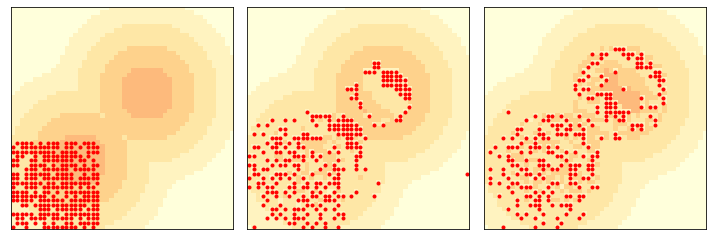

In [288]:
env = Sugarscape(50, agents=FarsightedAgent.make_agents(300, *lower_left))
three_frame(env, [0, 6, 6])
plt.show('figs/chap09-5')

This example is interesting because the waves move diagonally, unlike the agents, who can only move up or to the right.  They are similar in some ways to gliders and other Game of Life spaceships.

## Exercises

**Exercise:** Again, experiment with different starting conditions and see what effect they have on the wave behavior.

**Exercise:** In the first version of Sugarscape, we never add agents, so once the population falls, it never recovers.  In the second version, we only replace agents when they die, so the population is constant.  Now let's see what happens if we add some "population pressure".

Write a version of Sugarscape that adds a new agent at the end of every step.  Add code to track the average vision and the average metabolism of the agents at the end of each step.  Run the model for a few hundred steps and plot the population over time, as well as the average vision and average metabolism.

You should be able to implement this model by inheriting from
`Sugarscape` and overriding `__init__` and `step`.

In [283]:
# Solution goes here